In [21]:
# %% --- IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from smoothers import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm  
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set a consistent plot style
sns.set_theme(style="whitegrid")

print("Libraries imported successfully.")

Helper functions and classes defined.
Libraries imported successfully.


In [4]:
# %% --- STEP 1: LOAD DATASET & INITIAL DESCRIPTION ---

# --- Configuration ---
FILE_NAME = 'Life Expectancy Data.csv'
X_VAR_ORIGINAL = 'percentage expenditure' # This is Health Expenditure per Capita
Y_VAR_ORIGINAL = 'Life expectancy '      # This is Life Expectancy

try:
    df = pd.read_csv(FILE_NAME)
    print(f"Successfully loaded '{FILE_NAME}'.")

    # Clean column names
    df = clean_column_names(df)
    
    # Define cleaned variable names
    X_VAR = X_VAR_ORIGINAL.strip().lower().replace(' ', '_').replace('-', '_').replace('/', '_')
    Y_VAR = Y_VAR_ORIGINAL.strip().lower().replace(' ', '_').replace('-', '_').replace('/', '_')
    
    if X_VAR not in df.columns or Y_VAR not in df.columns:
        raise KeyError(f"Error: Columns '{X_VAR}' or '{Y_VAR}' not found. Check originals.")
    
    print(f"Using X Variable (Independent): '{X_VAR}'")
    print(f"Using Y Variable (Dependent): '{Y_VAR}'")

    print("\n--- Dataset Info (Initial) ---")
    df.info()

    print("\n--- Dataset Head (Initial) ---")
    print(df.head())
    
    print("\n--- Context for Report (Step 1) ---")
    print("Report Context: The dataset is the WHO Life Expectancy dataset, covering 193 countries from 2000-2015.")
    print(f"Report Context: This analysis focuses on the relationship between '{X_VAR}' (X) and '{Y_VAR}' (Y).")

except FileNotFoundError:
    print(f"Error: The file '{FILE_NAME}' was not found. Please make sure it is in the same directory.")
except KeyError as e:
    print(e)
    print(f"Available columns are: {list(df.columns)}")

Successfully loaded 'Life Expectancy Data.csv'.
Using X Variable (Independent): 'percentage_expenditure'
Using Y Variable (Dependent): 'life_expectancy'

--- Dataset Info (Initial) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles              

In [5]:
# %% --- STEP 2a: EDA - Summary Statistics ---
# Examine distributions of X and Y, globally and by 'status'.

print("\n--- Global Summary Statistics (X & Y) ---")
print(df[[X_VAR, Y_VAR]].describe())

print("\n--- Summary Statistics by 'status' (e.g., income groups) ---")
if 'status' in df.columns:
    print(df.groupby('status')[[X_VAR, Y_VAR]].describe())



--- Global Summary Statistics (X & Y) ---
       percentage_expenditure  life_expectancy
count             2938.000000      2928.000000
mean               738.251295        69.224932
std               1987.914858         9.523867
min                  0.000000        36.300000
25%                  4.685343        63.100000
50%                 64.912906        72.100000
75%                441.534144        75.700000
max              19479.911610        89.000000

--- Summary Statistics by 'status' (e.g., income groups) ---
           percentage_expenditure                                            \
                            count         mean          std  min        25%   
status                                                                        
Developed                   512.0  2703.600380  3824.200588  0.0  92.904052   
Developing                 2426.0   323.470285   846.655356  0.0   3.616102   

                                                  life_expectancy           


--- Missing Data Count per Column ---
country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under_five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hiv_aids                             0
gdp                                448
population                         652
thinness__1_19_years                34
thinness_5_9_years                  34
income_composition_of_resources    167
schooling                          163
dtype: int64

Saved missing data heatmap: missing_data_heatmap.png


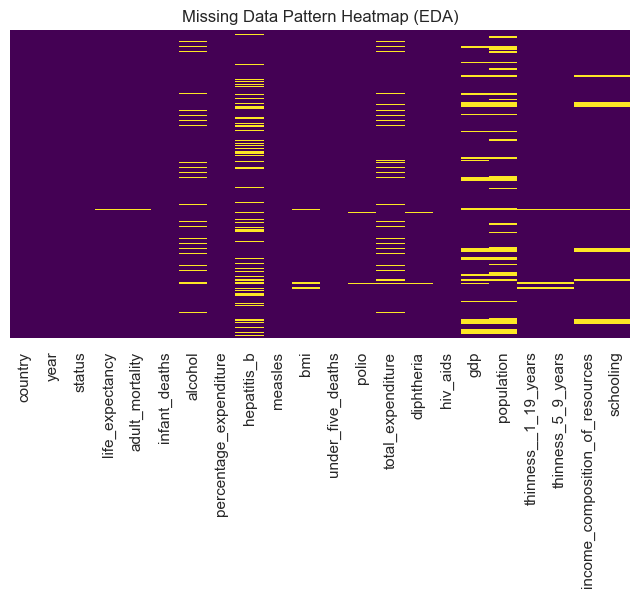

In [6]:
# %% --- STEP 2b: EDA - Missing Data Heatmap ---

print("\n--- Missing Data Count per Column ---")
print(df.isnull().sum())

plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern Heatmap (EDA)')
plt.savefig('missing_data_heatmap.png')
print("\nSaved missing data heatmap: missing_data_heatmap.png")
plt.show()


Saved EDA scatterplot by status: eda_scatterplot_all_by_status.png


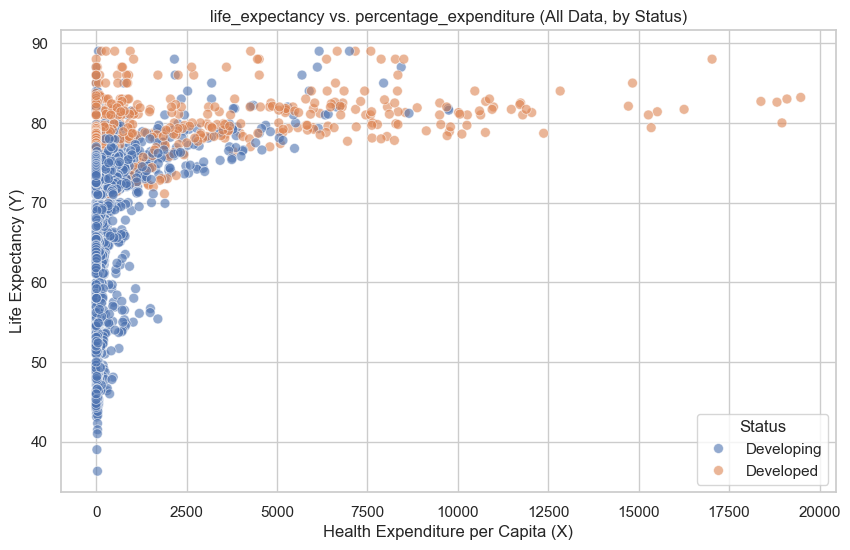

In [7]:
# %% --- STEP 2c: EDA - Global Scatterplot (by Status) ---

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=X_VAR, y=Y_VAR, hue='status', alpha=0.6, s=50)
plt.title(f'{Y_VAR} vs. {X_VAR} (All Data, by Status)')
plt.xlabel('Health Expenditure per Capita (X)')
plt.ylabel('Life Expectancy (Y)')
plt.legend(title='Status', loc='lower right')
plt.grid(True)
plt.savefig('eda_scatterplot_all_by_status.png')
print("Saved EDA scatterplot by status: eda_scatterplot_all_by_status.png")
plt.show()


Plotting time series for: United States of America, China, India, Germany, Brazil, Nigeria
Saved EDA time series plot: eda_timeseries_sample.png


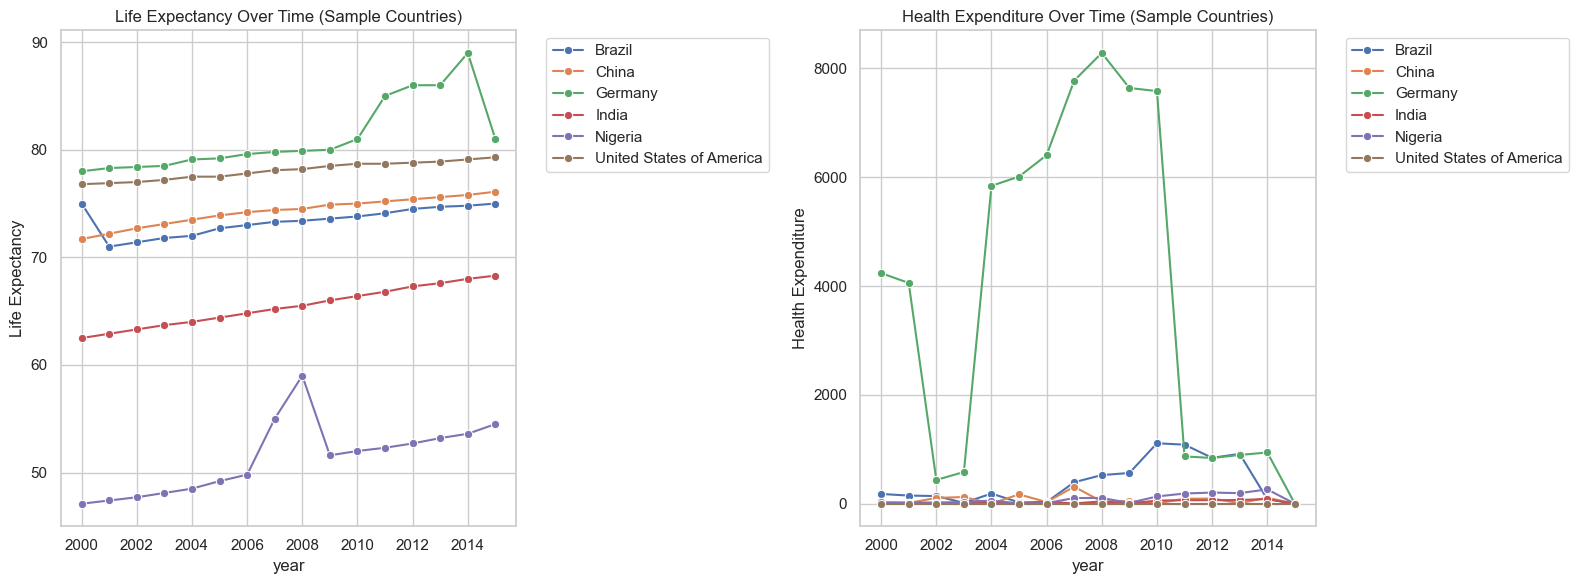

In [8]:
# %% --- STEP 2d: EDA - Time Series (Sample Countries) ---

sample_countries = ['United States of America', 'China', 'India', 'Germany', 'Brazil', 'Nigeria']
sample_countries = [c for c in sample_countries if c in df['country'].values]

if sample_countries:
    print(f"\nPlotting time series for: {', '.join(sample_countries)}")
    plt.figure(figsize=(16, 6))
    sample_df = df[df['country'].isin(sample_countries)]
    
    plt.subplot(1, 2, 1)
    sns.lineplot(data=sample_df, x='year', y=Y_VAR, hue='country', marker='o')
    plt.title('Life Expectancy Over Time (Sample Countries)')
    plt.ylabel('Life Expectancy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(1, 2, 2)
    sns.lineplot(data=sample_df, x='year', y=X_VAR, hue='country', marker='o')
    plt.title('Health Expenditure Over Time (Sample Countries)')
    plt.ylabel('Health Expenditure')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('eda_timeseries_sample.png')
    print("Saved EDA time series plot: eda_timeseries_sample.png")
    plt.show()

else:
    print("Sample countries not found in dataset.")

Initial row count (all data): 2938
Removed 10 rows with missing values in 'percentage_expenditure' or 'life_expectancy'.

Generating boxplots for outlier detection...
Saved boxplots for outlier analysis: cleaning_boxplots.png


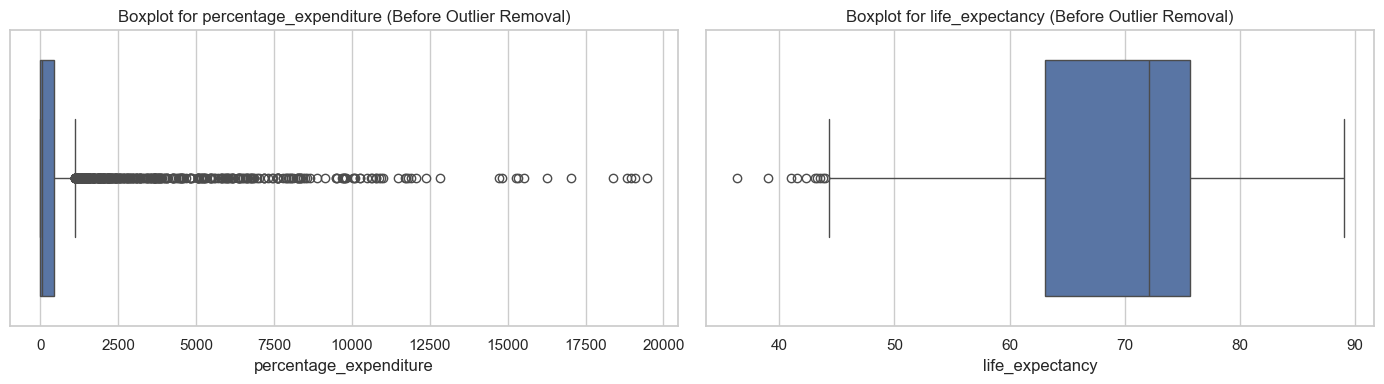

In [9]:
# %% --- STEP 3a: DATA CLEANING - Outlier Detection ---

model_df = df[[X_VAR, Y_VAR]].copy()
initial_rows = model_df.shape[0]
print(f"Initial row count (all data): {initial_rows}")

model_df.dropna(inplace=True)
rows_after_na = model_df.shape[0]
print(f"Removed {initial_rows - rows_after_na} rows with missing values in '{X_VAR}' or '{Y_VAR}'.")

print("\nGenerating boxplots for outlier detection...")
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=model_df[X_VAR])
plt.title(f'Boxplot for {X_VAR} (Before Outlier Removal)')

plt.subplot(1, 2, 2)
sns.boxplot(x=model_df[Y_VAR])
plt.title(f'Boxplot for {Y_VAR} (Before Outlier Removal)')

plt.tight_layout()
plt.savefig('cleaning_boxplots.png')
print("Saved boxplots for outlier analysis: cleaning_boxplots.png")
plt.show()


Outlier removal criteria: 'percentage_expenditure' < 10213.38 (99th percentile) AND 'life_expectancy' > 40.
Removed 32 rows as outliers.
Final dataset size for modeling: 2896 rows.

Plotting final cleaned data for modeling...
Saved final cleaned scatterplot: cleaned_data_scatterplot.png


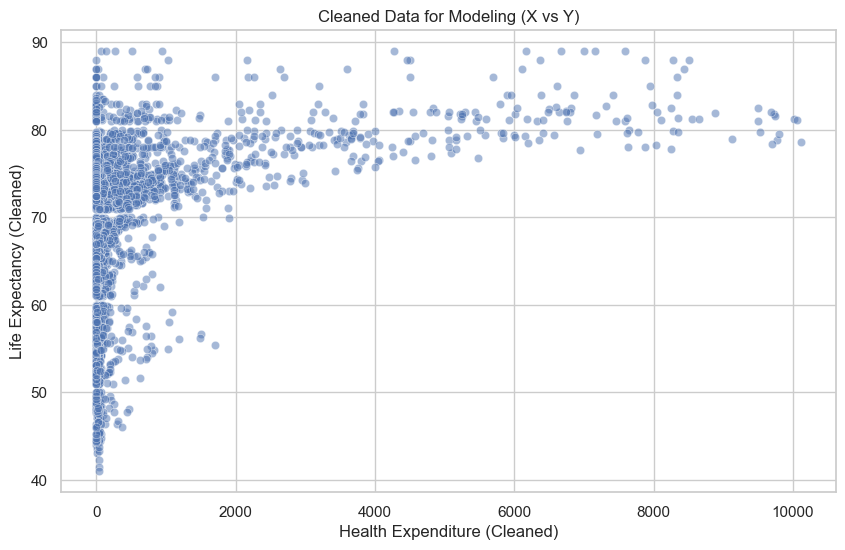


--- EDA Summary for Report ---
Report Summary: EDA revealed a strong non-linear relationship. 'Developed' countries show high spending and high life expectancy, while 'Developing' countries show high variance. A point of diminishing returns is visually evident. Time series plots show that for some countries, spending and life expectancy do not always move together.


In [10]:
# %% --- STEP 3b: DATA CLEANING - Outlier Removal & Final Plot ---

q_high_X = model_df[X_VAR].quantile(0.99)
q_low_Y = 40 

model_df_cleaned = model_df[(model_df[X_VAR] < q_high_X) & (model_df[Y_VAR] > q_low_Y)]
rows_after_outliers = model_df_cleaned.shape[0]

print(f"\nOutlier removal criteria: '{X_VAR}' < {q_high_X:.2f} (99th percentile) AND '{Y_VAR}' > {q_low_Y}.")
print(f"Removed {rows_after_na - rows_after_outliers} rows as outliers.")
print(f"Final dataset size for modeling: {rows_after_outliers} rows.")

print("\nPlotting final cleaned data for modeling...")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_df_cleaned, x=X_VAR, y=Y_VAR, alpha=0.5)
plt.title('Cleaned Data for Modeling (X vs Y)')
plt.xlabel('Health Expenditure (Cleaned)')
plt.ylabel('Life Expectancy (Cleaned)')
plt.grid(True)
plt.savefig('cleaned_data_scatterplot.png')
print("Saved final cleaned scatterplot: cleaned_data_scatterplot.png")
plt.show()

print("\n--- EDA Summary for Report ---")
print("Report Summary: EDA revealed a strong non-linear relationship. 'Developed' countries show high spending "
"and high life expectancy, while 'Developing' countries show high variance. A point of diminishing returns is visually evident. " \
"Time series plots show that for some countries, spending and life expectancy do not always move together.")

In [11]:
# %% --- STEP 4 (Setup): MODELING - Data Split & CV Setup ---
# Split data into Train/Test and prepare for modeling.

# Data split
X_data = model_df_cleaned[[X_VAR]]
y_data = model_df_cleaned[Y_VAR]

# Used .values for compatibility with all models
X_data_np = model_df_cleaned[X_VAR].values
y_data_np = model_df_cleaned[Y_VAR].values

X_train, X_test, y_train, y_test = train_test_split(X_data_np, y_data_np, test_size=0.2, random_state=42)

# Reshape for sklearn models
X_train_sk = X_train.reshape(-1, 1)
X_test_sk = X_test.reshape(-1, 1)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Plotting grid for visualizing the final curves
X_plot = np.linspace(X_data_np.min(), X_data_np.max(), 500)
X_plot_sk = X_plot.reshape(-1, 1) # for sklearn

# 5-Fold Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionaries to store results
results = {}
plot_curves = {}

print("Data split and CV setup complete.")


Training set size: 2316
Test set size: 580
Data split and CV setup complete.



Tuning: Method 1 - KNN Smoother (weights='uniform')
Saved CV plot: cv_plot_knn_smoother_uniform.png


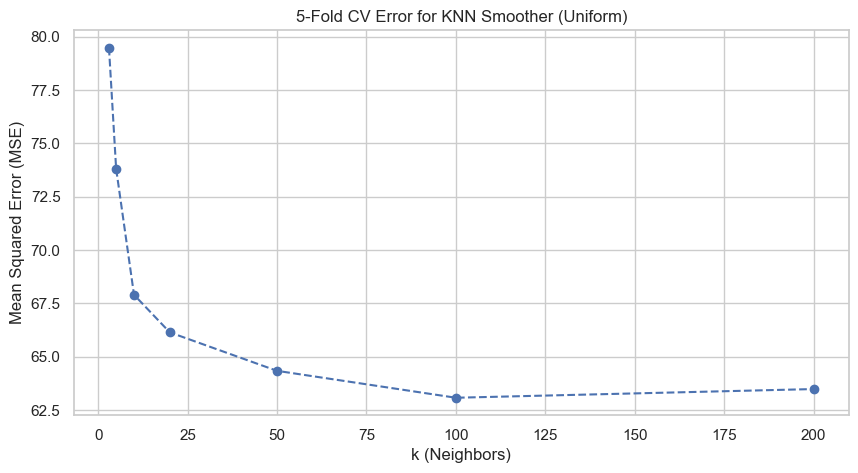

Best k: 100, Min Validation MSE: 63.0818, Test MSE: 66.7315


In [12]:
# %% --- STEP 4a: METHOD 1 - KNN Smoother (weights='uniform') ---

print("\nTuning: Method 1 - KNN Smoother (weights='uniform')")
k_values_knn = [3, 5, 10, 20, 50, 100, 200]
knn_cv_errors = []
for k in k_values_knn:
    model = KNeighborsRegressor(n_neighbors=k, weights='uniform')
    cv_scores = -cross_val_score(model, X_train_sk, y_train, cv=kf, scoring='neg_mean_squared_error')
    knn_cv_errors.append(cv_scores.mean())

plot_cv_results(k_values_knn, knn_cv_errors, 'k (Neighbors)', 'KNN Smoother (Uniform)')
best_k_knn = k_values_knn[np.argmin(knn_cv_errors)]

knn_model = KNeighborsRegressor(n_neighbors=best_k_knn, weights='uniform').fit(X_train_sk, y_train)
y_pred_knn = knn_model.predict(X_test_sk)
test_error_knn = mean_squared_error(y_test, y_pred_knn)

results['KNN (Uniform)'] = {'Best Hyperparameter': f"k={best_k_knn}", 'Validation MSE': min(knn_cv_errors), 'Test MSE': test_error_knn}
plot_curves['KNN (Uniform)'] = {'curve': knn_model.predict(X_plot_sk), 'label': f'KNN Uniform (k={best_k_knn})'}

print(f"Best k: {best_k_knn}, Min Validation MSE: {min(knn_cv_errors):.4f}, Test MSE: {test_error_knn:.4f}")


Tuning: Method 2 - KNN Kernel Smoother (weights='distance')
Saved CV plot: cv_plot_knn_kernel_distance.png


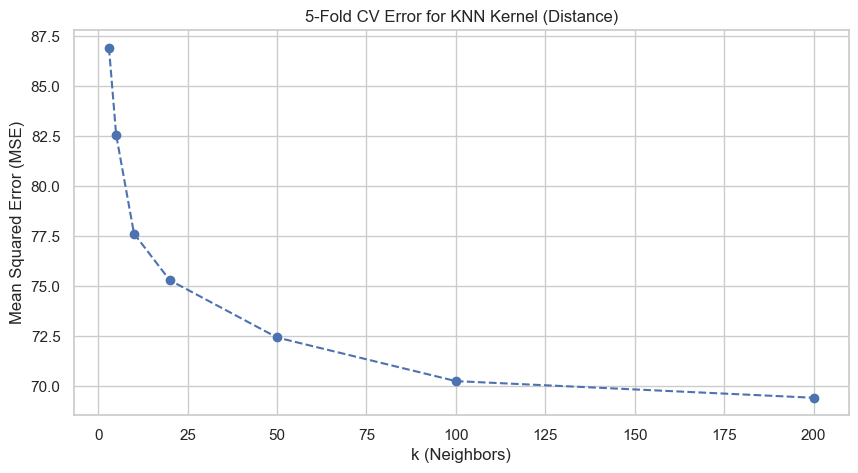

Best k: 200, Min Validation MSE: 69.4174, Test MSE: 73.7442


In [13]:
# %% --- STEP 4b: METHOD 2 - KNN Kernel Smoother (weights='distance') ---

print("\nTuning: Method 2 - KNN Kernel Smoother (weights='distance')")
k_values_kern = [3, 5, 10, 20, 50, 100, 200]
kern_cv_errors = []
for k in k_values_kern:
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    cv_scores = -cross_val_score(model, X_train_sk, y_train, cv=kf, scoring='neg_mean_squared_error')
    kern_cv_errors.append(cv_scores.mean())
    
plot_cv_results(k_values_kern, kern_cv_errors, 'k (Neighbors)', 'KNN Kernel (Distance)')
best_k_kern = k_values_kern[np.argmin(kern_cv_errors)]

kern_model = KNeighborsRegressor(n_neighbors=best_k_kern, weights='distance').fit(X_train_sk, y_train)
y_pred_kern = kern_model.predict(X_test_sk)
test_error_kern = mean_squared_error(y_test, y_pred_kern)

results['KNN (Distance)'] = {'Best Hyperparameter': f"k={best_k_kern}", 'Validation MSE': min(kern_cv_errors), 'Test MSE': test_error_kern}
plot_curves['KNN (Distance)'] = {'curve': kern_model.predict(X_plot_sk), 'label': f'KNN Distance (k={best_k_kern})'}

print(f"Best k: {best_k_kern}, Min Validation MSE: {min(kern_cv_errors):.4f}, Test MSE: {test_error_kern:.4f}")


Tuning: Method 3 - Bin Smoother
Saved CV plot: cv_plot_bin_smoother.png


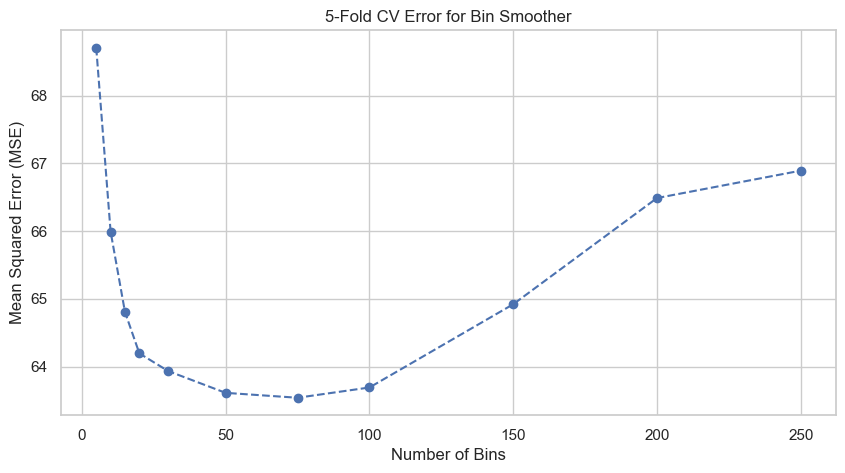

Best n_bins: 75, Min Validation MSE: 63.5385, Test MSE: 67.6238


In [14]:
# %% --- STEP 4c: METHOD 3 - Bin Smoother ---

print("\nTuning: Method 3 - Bin Smoother")
bin_values = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 250]
bin_cv_errors = []

for n_bins in bin_values:
    fold_errors = []
    for train_idx, val_idx in kf.split(X_train):
        # Get the training and validation folds
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Fit the bin smoother
        smoother = BinSmoother(n_bins=n_bins)
        smoother.fit(X_tr, y_tr)
        
        # Predict on the validation set
        y_pred = smoother.predict(X_val)
        fold_errors.append(mean_squared_error(y_val, y_pred))
    
    bin_cv_errors.append(np.mean(fold_errors))

plot_cv_results(bin_values, bin_cv_errors, 'Number of Bins', 'Bin Smoother')
best_bins = bin_values[np.argmin(bin_cv_errors)]

final_bin_smoother = BinSmoother(n_bins=best_bins)
final_bin_smoother.fit(X_train, y_train)
y_pred_bin = final_bin_smoother.predict(X_test)
test_error_bin = mean_squared_error(y_test, y_pred_bin)

results['Bin Smoother'] = {'Best Hyperparameter': f"n_bins={best_bins}", 'Validation MSE': min(bin_cv_errors), 'Test MSE': test_error_bin}
plot_curves['Bin Smoother'] = {'curve': final_bin_smoother.predict(X_plot), 'label': f'Bin Smoother (n_bins={best_bins})'}

print(f"Best n_bins: {best_bins}, Min Validation MSE: {min(bin_cv_errors):.4f}, Test MSE: {test_error_bin:.4f}")


Tuning: Method 4 - LOWESS (statsmodels)
Saved CV plot: cv_plot_lowess.png


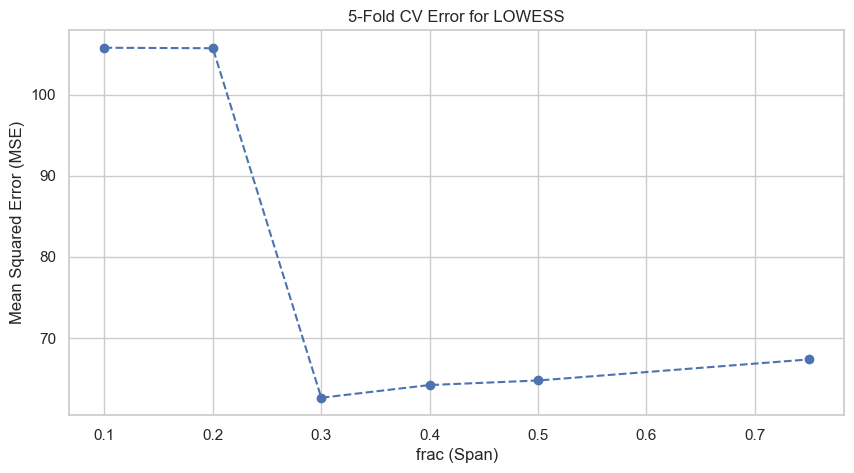

Best frac: 0.3, Min Validation MSE: 62.6197, Test MSE: 66.5921


In [15]:
# %% --- STEP 4d: METHOD 4 - LOWESS (from statsmodels) ---

print("\nTuning: Method 4 - LOWESS (statsmodels)")

lowess = sm.nonparametric.lowess
frac_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.75]
lowess_cv_errors = []

for frac in frac_values:
    fold_errors = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # LOWESS requires sorted X for fitting
        sort_idx = X_tr.argsort()
        
        # Fit LOWESS (it=0 for speed, non-robust)
        fitted = lowess(y_tr[sort_idx], X_tr[sort_idx], frac=frac, it=0)
        
        # Use interpolation to predict on the unsorted validation set
        y_pred = np.interp(X_val, fitted[:, 0], fitted[:, 1])
        fold_errors.append(mean_squared_error(y_val, y_pred))
        
    lowess_cv_errors.append(np.mean(fold_errors))

plot_cv_results(frac_values, lowess_cv_errors, 'frac (Span)', 'LOWESS')
best_frac = frac_values[np.argmin(lowess_cv_errors)]

# Fit final model on all *sorted* training data
train_sort_idx = X_train.argsort()
final_lowess = lowess(y_train[train_sort_idx], X_train[train_sort_idx], frac=best_frac, it=0)

# Predict on test and plot grids using interpolation
y_pred_lowess = np.interp(X_test, final_lowess[:, 0], final_lowess[:, 1])
test_error_lowess = mean_squared_error(y_test, y_pred_lowess)

results['LOWESS'] = {'Best Hyperparameter': f"frac={best_frac}", 'Validation MSE': min(lowess_cv_errors), 'Test MSE': test_error_lowess}
plot_curves['LOWESS'] = {'curve': np.interp(X_plot, final_lowess[:, 0], final_lowess[:, 1]), 'label': f'LOWESS (frac={best_frac})'}

print(f"Best frac: {best_frac}, Min Validation MSE: {min(lowess_cv_errors):.4f}, Test MSE: {test_error_lowess:.4f}")


Tuning: Method 5 - Kernel Smoother (Gaussian)
  Testing Kernel bandwidth: 0.05...
  Testing Kernel bandwidth: 0.5...
  Testing Kernel bandwidth: 1...
  Testing Kernel bandwidth: 5...
  Testing Kernel bandwidth: 15...
  Testing Kernel bandwidth: 25...
  Testing Kernel bandwidth: 50...
  Testing Kernel bandwidth: 100...
  Testing Kernel bandwidth: 200...
  Testing Kernel bandwidth: 500...
  Testing Kernel bandwidth: 1000...
Saved CV plot: cv_plot_kernel_smoother_gaussian.png


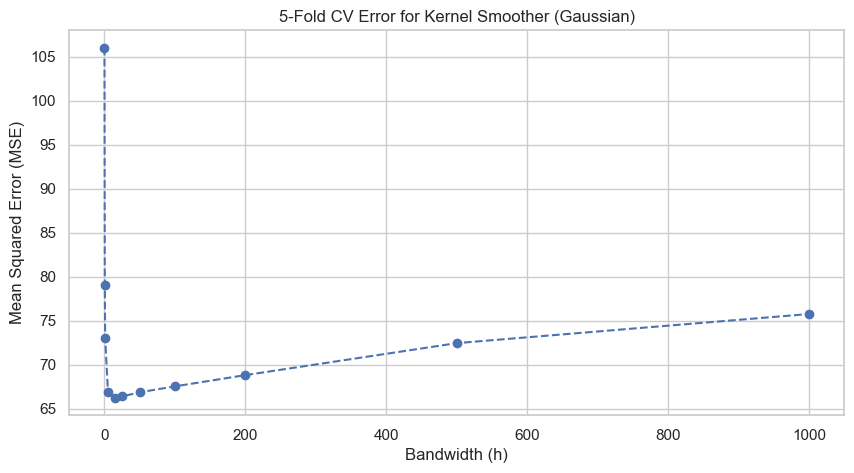

Best bandwidth: 15, Min Validation MSE: 66.2532, Test MSE: 68.2348


In [16]:
# %% --- STEP 4e: METHOD 5 - Kernel Smoother (Nadaraya-Watson) ---

print("\nTuning: Method 5 - Kernel Smoother (Gaussian)")
# Data X values are in the 1000s, so bandwidths need to be large
bandwidth_values = [0.05, 0.5, 1, 5, 15, 25, 50, 100, 200, 500, 1000] 
kernel_cv_errors = []

for bw in bandwidth_values:
    fold_errors = []
    print(f"  Testing Kernel bandwidth: {bw}...") # Progress update
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Predict on the validation set
        y_pred = kernel_smoother(X_tr, y_tr, X_val, bandwidth=bw)
        fold_errors.append(mean_squared_error(y_val, y_pred))
        
    kernel_cv_errors.append(np.mean(fold_errors))

plot_cv_results(bandwidth_values, kernel_cv_errors, 'Bandwidth (h)', 'Kernel Smoother (Gaussian)')
best_bw_kernel = bandwidth_values[np.argmin(kernel_cv_errors)]

y_pred_kernel = kernel_smoother(X_train, y_train, X_test, bandwidth=best_bw_kernel)
test_error_kernel = mean_squared_error(y_test, y_pred_kernel)

results['Kernel (Gaussian)'] = {'Best Hyperparameter': f"h={best_bw_kernel}", 'Validation MSE': min(kernel_cv_errors), 'Test MSE': test_error_kernel}
plot_curves['Kernel (Gaussian)'] = {'curve': kernel_smoother(X_train, y_train, X_plot, bandwidth=best_bw_kernel), 'label': f'Kernel (h={best_bw_kernel})'}

print(f"Best bandwidth: {best_bw_kernel}, Min Validation MSE: {min(kernel_cv_errors):.4f}, Test MSE: {test_error_kernel:.4f}")



Tuning: Method 6 - Local Linear Regression (Tricube)
  Testing LocalReg bandwidth: 5...
  Testing LocalReg bandwidth: 10...
  Testing LocalReg bandwidth: 15...
  Testing LocalReg bandwidth: 25...
  Testing LocalReg bandwidth: 50...
  Testing LocalReg bandwidth: 100...
  Testing LocalReg bandwidth: 200...
  Testing LocalReg bandwidth: 500...
  Testing LocalReg bandwidth: 1000...
Saved CV plot: cv_plot_local_regression_tricube.png


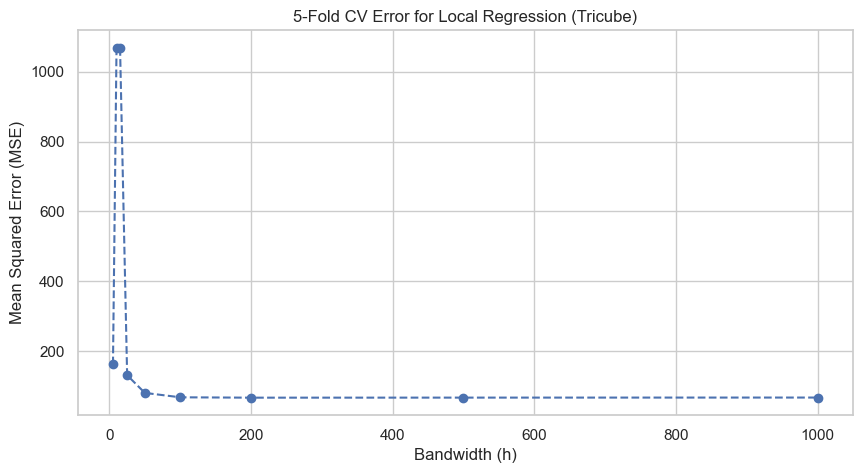


Calculating final predictions for Local Regression (Bandwidth=200)...
Calculating plot curve for Local Regression...
Best bandwidth: 200, Min Validation MSE: 67.3616, Test MSE: 69.4829


In [17]:
# %% --- STEP 4f: METHOD 6 - Local Linear Regression (Tricube) ---
# This is computationally VERY SLOW 

print("\nTuning: Method 6 - Local Linear Regression (Tricube)")
# Data X values are in the 1000s, so bandwidths need to be large
bandwidth_values_loc = [5, 10, 15, 25, 50, 100, 200, 500, 1000] 
locreg_cv_errors = []

for bw in bandwidth_values_loc:
    fold_errors = []
    print(f"  Testing LocalReg bandwidth: {bw}...") # Progress update
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Predict on each point in the validation set (this is the slow part)
        y_pred = [locally_weighted_regression(x, X_tr, y_tr, bandwidth=bw) for x in X_val]
        fold_errors.append(mean_squared_error(y_val, y_pred))
        
    locreg_cv_errors.append(np.mean(fold_errors))

plot_cv_results(bandwidth_values_loc, locreg_cv_errors, 'Bandwidth (h)', 'Local Regression (Tricube)')
best_bw_locreg = bandwidth_values_loc[np.argmin(locreg_cv_errors)]

print(f"\nCalculating final predictions for Local Regression (Bandwidth={best_bw_locreg})...")
y_pred_locreg = [locally_weighted_regression(x, X_train, y_train, bandwidth=best_bw_locreg) for x in X_test]
test_error_locreg = mean_squared_error(y_test, y_pred_locreg)

results['Local Regression'] = {'Best Hyperparameter': f"h={best_bw_locreg}", 'Validation MSE': min(locreg_cv_errors), 'Test MSE': test_error_locreg}

# Calculate plot curve (also slow, so we print progress)
print("Calculating plot curve for Local Regression...")
curve_locreg = [locally_weighted_regression(x, X_train, y_train, bandwidth=best_bw_locreg) for x in X_plot]
plot_curves['Local Regression'] = {'curve': curve_locreg, 'label': f'LocalReg (h={best_bw_locreg})'}

print(f"Best bandwidth: {best_bw_locreg}, Min Validation MSE: {min(locreg_cv_errors):.4f}, Test MSE: {test_error_locreg:.4f}")

In [18]:
# %% --- STEP 5a: MODEL COMPARISON - Results Table ---

results_df = pd.DataFrame(results).T
results_df.index.name = 'Method'

print("\n--- Final Model Comparison Table (for Report) ---")
print(results_df.to_markdown(floatfmt='.4f'))



--- Final Model Comparison Table (for Report) ---
| Method            | Best Hyperparameter   |   Validation MSE |   Test MSE |
|:------------------|:----------------------|-----------------:|-----------:|
| KNN (Uniform)     | k=100                 |          63.0818 |    66.7315 |
| KNN (Distance)    | k=200                 |          69.4174 |    73.7442 |
| Bin Smoother      | n_bins=75             |          63.5385 |    67.6238 |
| LOWESS            | frac=0.3              |          62.6197 |    66.5921 |
| Kernel (Gaussian) | h=15                  |          66.2532 |    68.2348 |
| Local Regression  | h=200                 |          67.3616 |    69.4829 |



Generating final model comparison plot...
Saved final model comparison plot: final_model_comparison_plot.png


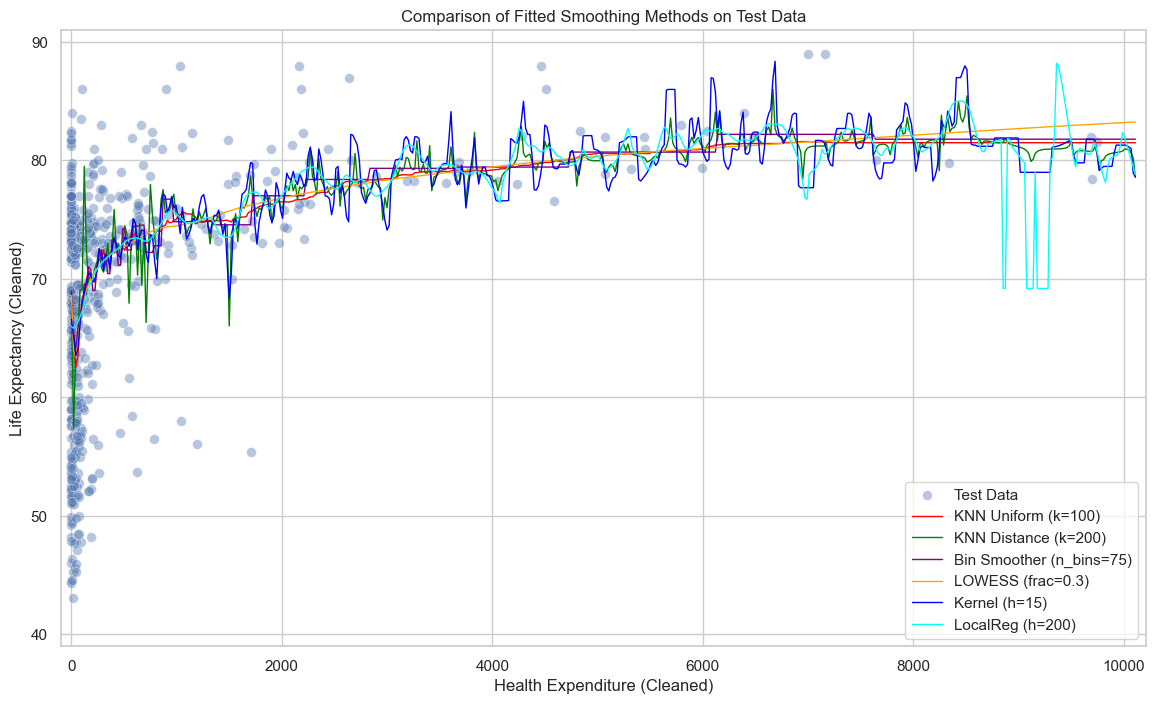

In [19]:
# %% --- STEP 5b: MODEL COMPARISON - Final Visualization ---
# Plot all six fitted curves on the test data scatterplot.

print("\nGenerating final model comparison plot...")
plt.figure(figsize=(14, 8))
# Plot the test data points
sns.scatterplot(x=X_test, y=y_test, alpha=0.4, label='Test Data', s=50)

# Updated color list for 6 models
colors = ['red', 'green', 'purple', 'orange', 'blue', 'cyan']

for (name, plot_data), color in zip(plot_curves.items(), colors):
    # Plot the fitted curve
    plt.plot(X_plot, plot_data['curve'], color=color, linewidth=1, label=plot_data['label'])

plt.title('Comparison of Fitted Smoothing Methods on Test Data')
plt.xlabel('Health Expenditure (Cleaned)')
plt.ylabel('Life Expectancy (Cleaned)')
plt.legend()
plt.grid(True)
plt.ylim(y_data_np.min() - 2, y_data_np.max() + 2)
plt.xlim(X_data_np.min() - 100, X_data_np.max() + 100)
plt.savefig('final_model_comparison_plot.png')
print("Saved final model comparison plot: final_model_comparison_plot.png")
plt.show()


Generating individual plots for each best model...
Saved individual plot: final_plot_knn_uniform.png


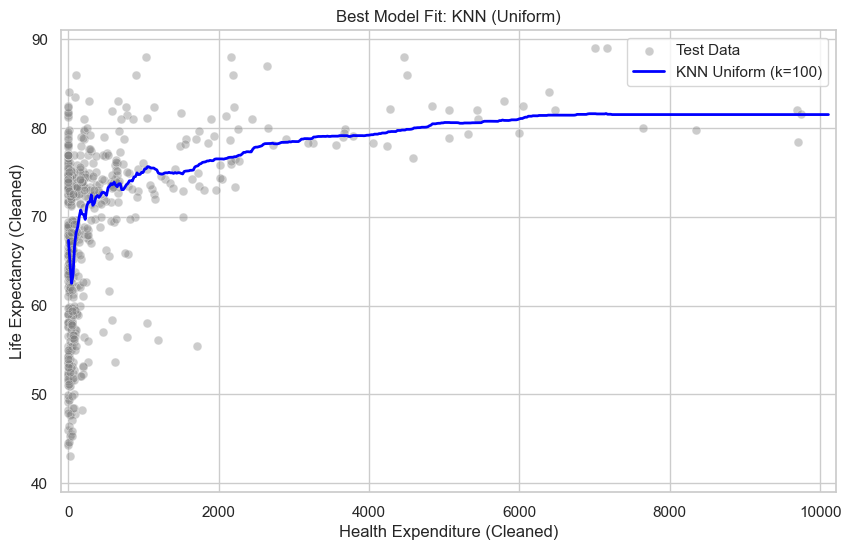

Saved individual plot: final_plot_knn_distance.png


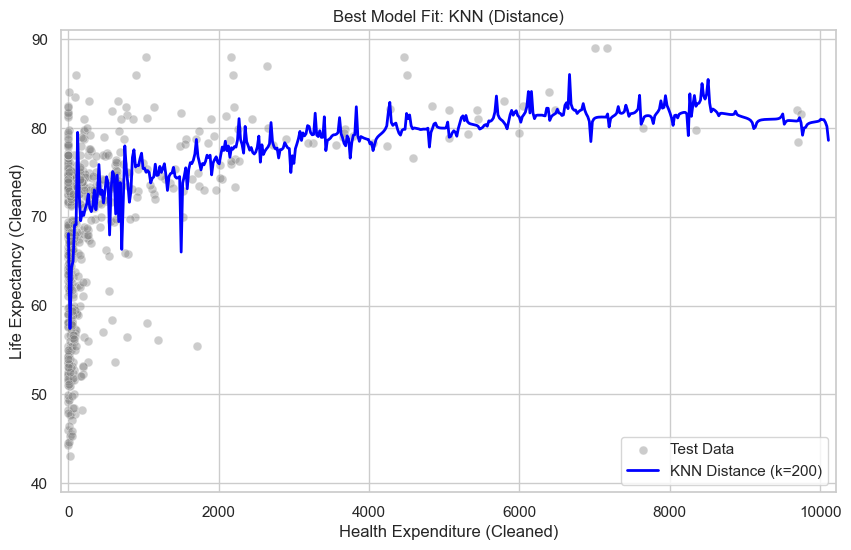

Saved individual plot: final_plot_bin_smoother.png


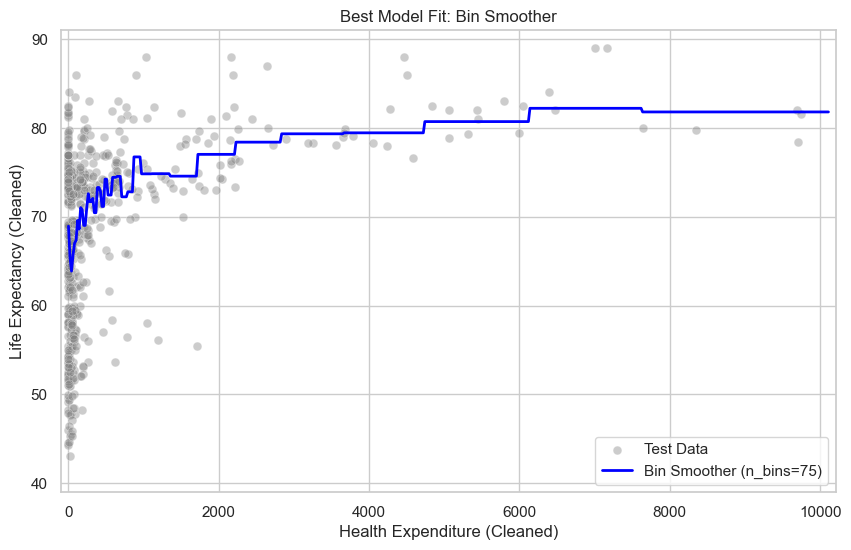

Saved individual plot: final_plot_lowess.png


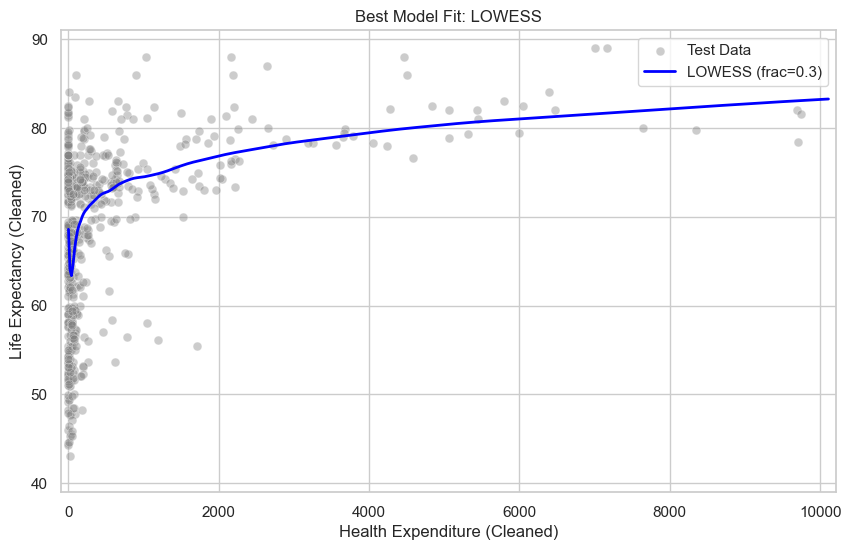

Saved individual plot: final_plot_kernel_gaussian.png


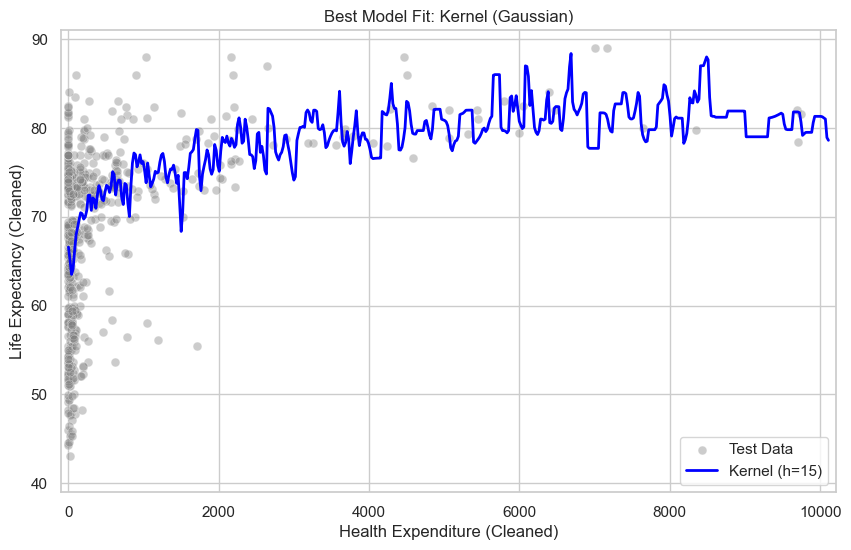

Saved individual plot: final_plot_local_regression.png


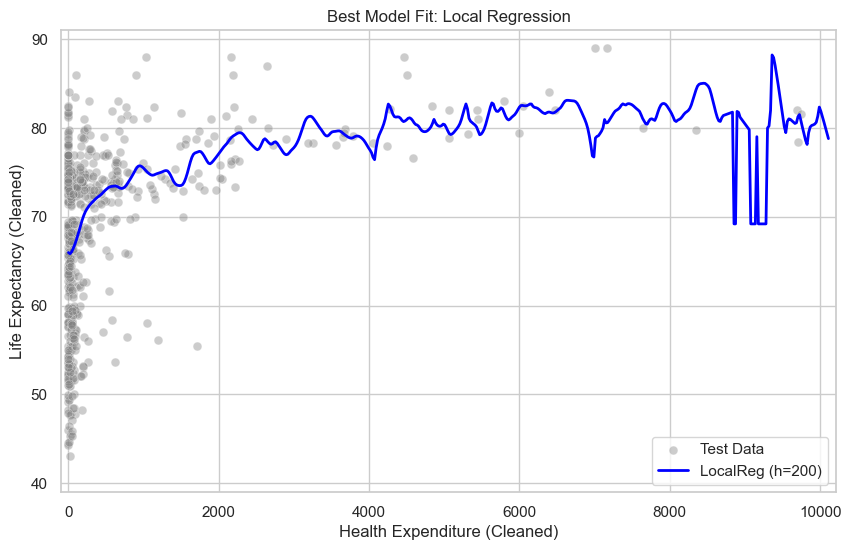


Finished generating all individual model plots.


In [20]:
# %% --- STEP 5c: INDIVIDUAL PLOTS FOR BEST MODELS ---

print("\nGenerating individual plots for each best model...")

# Loop through each model we stored in the 'plot_curves' dictionary
for name, plot_data in plot_curves.items():
    
    # 1. Creates a new, fresh figure for this model
    plt.figure(figsize=(10, 6))
    
    # 2. Plots the test data scatterplot
    sns.scatterplot(x=X_test, y=y_test, alpha=0.4, label='Test Data', s=40, color='gray')
    
    # 3. Plots fitted curve for this model
    plt.plot(X_plot, plot_data['curve'], color='blue', linewidth=2, label=plot_data['label'])
    
    # 4. Add titles and labels
    plt.title(f'Best Model Fit: {name}')
    plt.xlabel('Health Expenditure (Cleaned)')
    plt.ylabel('Life Expectancy (Cleaned)')
    
    # 5. Using the same axis limits as the combined plot for a fair comparison
    plt.ylim(y_data_np.min() - 2, y_data_np.max() + 2)
    plt.xlim(X_data_np.min() - 100, X_data_np.max() + 100)
    
    plt.legend()
    plt.grid(True)
    
    # 6. Save the plot to a unique file
    filename = f"final_plot_{name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(filename)
    print(f"Saved individual plot: {filename}")
    
    # 7. Show the plot
    plt.show()

print("\nFinished generating all individual model plots.")